<a href="https://colab.research.google.com/github/Ssurf777/VAE_sample/blob/main/outside_pinn/cVAE_outside_pinn_LatentSpace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PINNモデルの作成

https://github.com/Ssurf777/physics_informed_neural_network/blob/main/PINNs_Heat_Diffusion_Chair.ipynb

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install faiss-cpu

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import random
import faiss
import time
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import DBSCAN

# ランダムシードの設定
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [ ]:
def read_off(file):
    if 'OFF' != file.readline().strip():
        raise ValueError('Not a valid OFF header')
    n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
    verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
    return verts, faces


In [ ]:
# 内挿域サンプリング
class PointSampler(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size

    def triangle_area(self, pt1, pt2, pt3):
        side_a = np.linalg.norm(pt1 - pt2)
        side_b = np.linalg.norm(pt2 - pt3)
        side_c = np.linalg.norm(pt3 - pt1)
        s = 0.5 * (side_a + side_b + side_c)
        return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

    def sample_point(self, pt1, pt2, pt3):
        s, t = sorted([random.random(), random.random()])
        f = lambda i: s * pt1[i] + (t - s) * pt2[i] + (1 - t) * pt3[i]
        return (f(0), f(1), f(2))

    def __call__(self, mesh):
        verts, faces = mesh
        verts = np.array(verts)
        areas = np.zeros((len(faces)))

        for i in range(len(areas)):
            areas[i] = self.triangle_area(verts[faces[i][0]],
                                          verts[faces[i][1]],
                                          verts[faces[i][2]])

        sampled_faces = random.choices(faces, weights=areas, k=self.output_size)
        sampled_points = np.zeros((self.output_size, 3))

        for i in range(len(sampled_faces)):
            sampled_points[i] = self.sample_point(verts[sampled_faces[i][0]],
                                                  verts[sampled_faces[i][1]],
                                                  verts[sampled_faces[i][2]])
        return sampled_points

In [ ]:
# 点群生成とクラスター化
def create_chair_points(num_points=500, radius=1.0):
    file_names = [f"/content/drive/MyDrive/chair/chair_{i:04d}.off" for i in range(1,2)]
    for file_name in file_names:
        with open(file_name, 'r') as f:
            verts, faces = read_off(f)
            i,j,k = np.array(faces).T
            x,y,z = np.array(verts).T

            pointcloud = PointSampler(num_points)((verts,faces))

            # traindata
            train_x = pointcloud[:,0]
            train_y = pointcloud[:,1]
            train_z = pointcloud[:,2]
            # Convert NumPy arrays to PyTorch tensors before normalization
            train_x = torch.tensor(train_x)
            train_y = torch.tensor(train_y)
            train_z = torch.tensor(train_z)
            train_xn = (train_x - train_x.min() )/ (train_x.max() - train_x.min())
            train_yn = (train_y - train_y.min() )/ (train_y.max() - train_y.min())
            train_zn = (train_z - train_z.min() )/ (train_z.max() - train_z.min())
            return torch.stack([train_xn, train_yn, train_zn], dim=1)

In [ ]:
# クラスタリング
def create_clusters(points, k=4):
    distances = torch.cdist(points, points)
    clusters = []
    for i in range(len(points)):
        closest_neighbors_idx = torch.topk(distances[i], k + 1, largest=False)[1][1:]
        clusters.append(points[closest_neighbors_idx])
    return clusters

# k-means クラスタリング
def create_clusters_with_kmeans(points, k=4, n_clusters=10):
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42).fit(points.cpu().numpy())
    labels = kmeans.labels_
    clusters = []

    for label in range(n_clusters):
        cluster_points = points[torch.tensor(labels) == label]
        if len(cluster_points) > k:
            clusters.extend(create_clusters(cluster_points, k=k))
        else:
            clusters.append(cluster_points)

    return clusters

# DBSCAN クラスタリング
def create_clusters_with_DBSCAN(points, eps=0.5, min_samples=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    points_np = points.to(device).float().detach().cpu().numpy()

    # Perform DBSCAN clustering
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(points_np)

    # Create clusters based on labels
    labels = db.labels_
    clusters = [points[torch.tensor(labels == i, device=device)] for i in range(max(labels) + 1)]

    return clusters

In [ ]:
# ラプラシアンの計算
def compute_laplacian_with_clusters(model, clusters):
    laplacians = []
    for cluster in clusters:
        cluster.requires_grad_(True)
        T = model(cluster)

        grad_T = torch.autograd.grad(outputs=T, inputs=cluster,
                                     grad_outputs=torch.ones_like(T),
                                     create_graph=True)[0]

        laplacian = 0
        for i in range(cluster.shape[1]):
            grad2_T = torch.autograd.grad(grad_T[:, i], cluster,
                                          grad_outputs=torch.ones_like(grad_T[:, i]),
                                          create_graph=True, retain_graph=True)[0][:, i]
            laplacian += grad2_T

        laplacians.append(laplacian.mean())
    return torch.stack(laplacians)

def compute_laplacian_with_clusters_batch(model, clusters, batch_size=32):
    laplacians = []
    for i in range(0, len(clusters), batch_size):
        batch = clusters[i:i+batch_size]
        batch = torch.stack(batch).to(next(model.parameters()).device)
        batch.requires_grad_(True)

        T = model(batch)

        grad_T = torch.autograd.grad(outputs=T, inputs=batch,
                                     grad_outputs=torch.ones_like(T),
                                     create_graph=True, allow_unused=True)[0]

        if grad_T is None:
            #print("grad_T is None, skipping this batch.")
            continue

        laplacians_batch = []
        for j in range(batch.shape[0]):
            laplacian = torch.tensor(0.0, device=batch.device)  # Tensorとして初期化
            for i in range(batch.shape[2]):
                grad2_T = torch.autograd.grad(grad_T[j][:, i], batch[j],
                                              grad_outputs=torch.ones_like(grad_T[j][:, i]),
                                              create_graph=True, retain_graph=True,
                                              allow_unused=True)[0]
                if grad2_T is None:
                    #print(f"grad2_T is None for batch {j}, skipping this gradient.")
                    continue

                laplacian += grad2_T
            laplacians_batch.append(laplacian.mean())

        laplacians.extend(laplacians_batch)

    return torch.stack(laplacians)
# ======================================================================================================
# クラスタリングなしのラプラシアンの計算
def compute_laplacian_without_clustering(model, points):
    points.requires_grad_(True)
    T = model(points)

    # 勾配 (一次微分) の計算
    grad_T = torch.autograd.grad(outputs=T, inputs=points,
                                 grad_outputs=torch.ones_like(T),
                                 create_graph=True)[0]

    # 二次微分（ラプラシアン）の計算
    laplacian = torch.zeros(points.shape[0], device=points.device)
    for i in range(points.shape[1]):  # 各次元 (x, y, z) に対して
        grad2_T = torch.autograd.grad(grad_T[:, i], points,
                                      grad_outputs=torch.ones_like(grad_T[:, i]),
                                      create_graph=True, retain_graph=True)[0][:, i]
        laplacian += grad2_T

    return laplacian.mean()  # 平均を取る

In [ ]:
# モデル定義
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(3, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x.float()))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [ ]:
# PINNの学習
def train_pinn_with_clusters(model, points, heat_source, epochs=100, k=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    points = points.to(device)
    heat_source = heat_source.to(device)

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    #clusters = create_clusters_with_kmeans(points, k=k) # k-meansクラスタリング
    clusters = create_clusters_with_DBSCAN(points, eps=0.5, min_samples=4) # DBSCANクラスタリング
    start_time = time.time()  # 学習全体の開始時間

    for epoch in range(epochs):
        epoch_start_time = time.time()  # エポックの開始時間
        model.train()
        total_loss = 0

        for i, point in enumerate(points):
            distance_to_source = torch.norm(point - heat_source)
            expected_temperature = 1 / (distance_to_source + 1e-8)

            laplacian = compute_laplacian_with_clusters(model, clusters)
            #laplacian = compute_laplacian_with_clusters_batch(model, [clusters[i]], batch_size=32)
            loss_laplacian = torch.mean(laplacian[0] ** 2)
            loss_temperature = torch.mean((model(point.unsqueeze(0)) - expected_temperature) ** 2)

            loss = loss_laplacian + loss_temperature
            total_loss += loss.item()

            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()

        # エポックの経過時間を計算
        epoch_time = time.time() - epoch_start_time
        # 全体の経過時間
        elapsed_time = time.time() - start_time
        # 残りのエポック数
        remaining_epochs = epochs - (epoch + 1)
        # 残り時間の推定
        estimated_remaining_time = (elapsed_time / (epoch + 1)) * remaining_epochs

        if epoch % 10 == 0:
            print(f"Epoch: {epoch + 1}/{epochs} | Elapsed Time: {elapsed_time:.2f}s | Estimated Remaining Time: {estimated_remaining_time:.2f}s")
            print(f'Epoch {epoch + 1}, Loss: {total_loss / len(points)}')

In [ ]:
# 使用例
points = create_chair_points()
#model = PINN()
#train_pinn_with_clusters(model, points, torch.tensor([1, 1, 1]))  # 任意の熱源を設定

Epoch: 1/100 | Elapsed Time: 10.95s | Estimated Remaining Time: 1084.15s
Epoch 1, Loss: 1.1507390145030785
Epoch: 11/100 | Elapsed Time: 72.42s | Estimated Remaining Time: 585.98s
Epoch 11, Loss: 0.12268411131515532
Epoch: 21/100 | Elapsed Time: 134.43s | Estimated Remaining Time: 505.72s
Epoch 21, Loss: 0.08882380209236368
Epoch: 31/100 | Elapsed Time: 195.12s | Estimated Remaining Time: 434.31s
Epoch 31, Loss: 0.08913568637704453
Epoch: 41/100 | Elapsed Time: 254.76s | Estimated Remaining Time: 366.61s
Epoch 41, Loss: 0.08288756260572802
Epoch: 51/100 | Elapsed Time: 312.60s | Estimated Remaining Time: 300.34s
Epoch 51, Loss: 0.07478481632206711
Epoch: 61/100 | Elapsed Time: 372.52s | Estimated Remaining Time: 238.17s
Epoch 61, Loss: 0.07872073826312126
Epoch: 71/100 | Elapsed Time: 434.07s | Estimated Remaining Time: 177.30s
Epoch 71, Loss: 0.06832094225365651
Epoch: 81/100 | Elapsed Time: 493.96s | Estimated Remaining Time: 115.87s
Epoch 81, Loss: 0.06943480939550661
Epoch: 91/100 

In [ ]:
# model save
#torch.save(model.state_dict(),'/content/drive/MyDrive/chair/Heat_PINN_for_VAE_0924.pth')
print("Model weights have been saved!")

Model weights have been saved!


# cVAEの作成

https://github.com/Ssurf777/VAE_sample/blob/main/ModelNet10_Chair_VAE/modelnet10_rotation_Pointnet_VAE_%E6%AC%A1%E5%85%83%E7%B8%AE%E9%80%80tsne_LReLU.ipynb

In [1]:

import os
import numpy as np
import random
import math

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader,TensorDataset
from torchvision import transforms, utils

import scipy.spatial.distance
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
import pandas as pd

In [2]:
import numpy as np
import plotly.graph_objs as go

def read_off(file):
    if 'OFF' != file.readline().strip():
        raise ValueError('Not a valid OFF header')
    n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
    verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
    return verts, faces

def visualize_rotate(data):
    x_eye, y_eye, z_eye = 1.25, 1.25, 0.8
    frames = []

    def rotate_z(x, y, z, theta):
        w = x + 1j * y
        return np.real(np.exp(1j * theta) * w), np.imag(np.exp(1j * theta) * w), z

    for t in np.arange(0, 10.26, 0.1):
        xe, ye, ze = rotate_z(x_eye, y_eye, z_eye, -t)
        frames.append(dict(layout=dict(scene=dict(camera=dict(eye=dict(x=xe, y=ye, z=ze))))))

    fig = go.Figure(
        data=data,
        layout=go.Layout(
            updatemenus=[dict(
                type='buttons',
                showactive=False,
                y=1,
                x=0.8,
                xanchor='left',
                yanchor='bottom',
                pad=dict(t=45, r=10),
                buttons=[dict(
                    label='Play',
                    method='animate',
                    args=[None, dict(
                        frame=dict(duration=50, redraw=True),
                        transition=dict(duration=0),
                        fromcurrent=True,
                        mode='immediate'
                    )]
                )]
            )],
        ),
        frames=frames
    )
    return fig

def pcshow(xs, ys, zs):
    data = [go.Scatter3d(x=xs, y=ys, z=zs, mode='markers')]
    fig = visualize_rotate(data)
    fig.update_traces(
        marker=dict(
            size=2,
            line=dict(
                width=2,
                color='DarkSlateGrey'
            )
        ),
        selector=dict(mode='markers')
    )
    fig.show()


In [4]:
# 内挿域サンプリング
class PointSampler(object):
  def __init__(self, output_size):
    assert isinstance(output_size, int)
    self.output_size = output_size

  def triangle_area(self, pt1, pt2, pt3):
    side_a = np.linalg.norm(pt1 - pt2)
    side_b = np.linalg.norm(pt2 - pt3)
    side_c = np.linalg.norm(pt3 - pt1)
    s = 0.5 * (side_a + side_b + side_c)
    return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

  def sample_point(self, pt1, pt2, pt3):
    s, t = sorted([random.random(),random.random()])
    f = lambda i: s * pt1[i] + (t-s)*pt2[i] + (1-t)*pt3[i]
    return (f(0), f(1), f(2))

  def __call__(self,mesh):
    verts, faces = mesh
    verts = np.array(verts)
    areas = np.zeros((len(faces)))

    for i in range(len(areas)):
      areas[i] = (self.triangle_area(verts[faces[i][0]],
                                     verts[faces[i][1]],
                                     verts[faces[i][2]]))
      sampled_faces = (random.choices(faces,
                                      weights=areas,
                                      cum_weights=None,
                                      k=self.output_size))
      sampled_points = np.zeros((self.output_size,3))
    for i in range(len(sampled_faces)):
      sampled_points[i] = (self.sample_point(verts[sampled_faces[i][0]],
                                             verts[sampled_faces[i][1]],
                                             verts[sampled_faces[i][2]]))
    return sampled_points

In [5]:
np.random.seed(42)
torch.manual_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

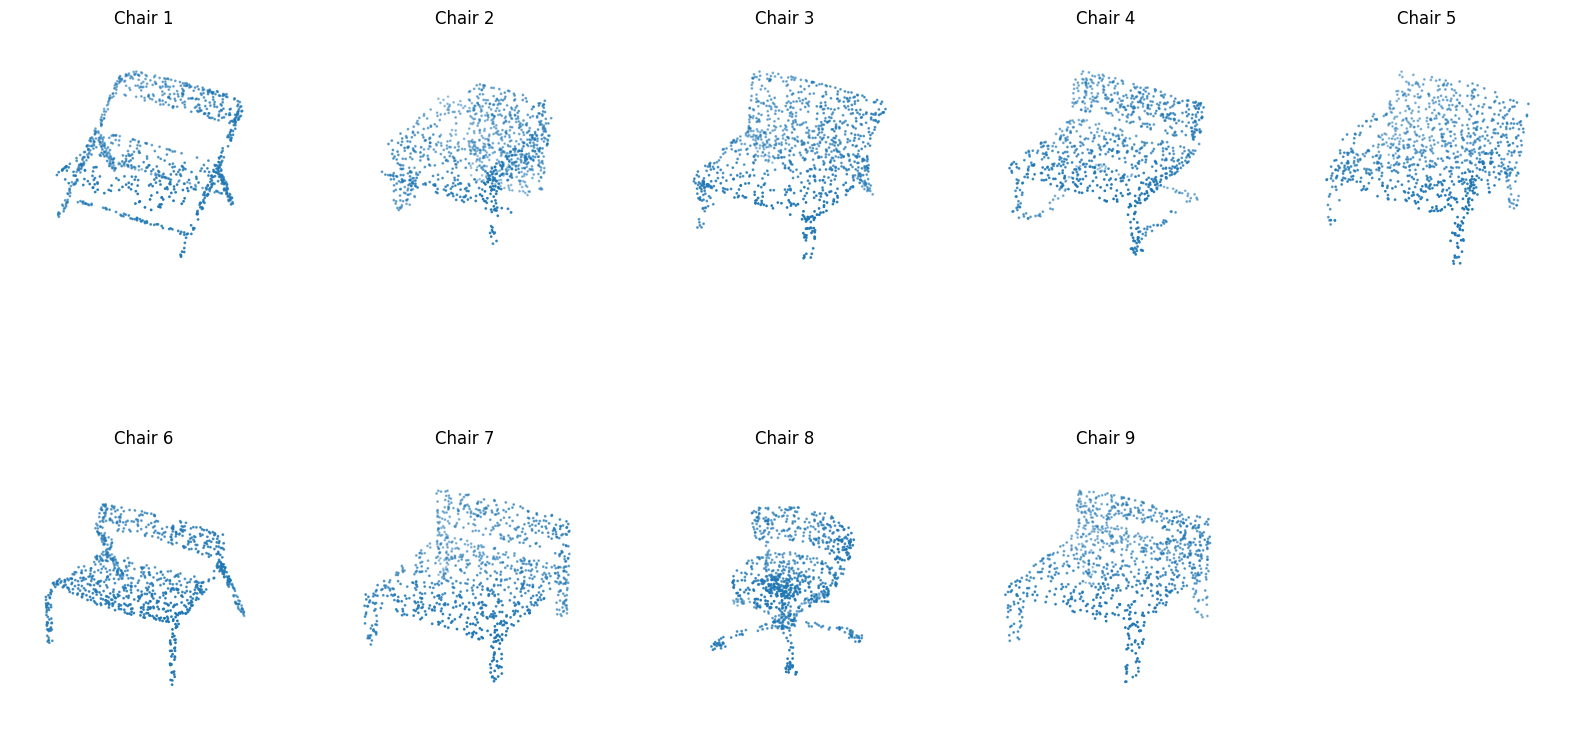

In [21]:
file_names = [f"/content/drive/MyDrive/chair/chair_{i:04d}.off" for i in range(1,10)]

input_data_list = []
input_data_list2 = []

for file_name in file_names:
  with open(file_name, 'r') as f:
    verts, faces = read_off(f)

    i,j,k = np.array(faces).T
    x,y,z = np.array(verts).T

    pointcloud = PointSampler(1000)((verts,faces))

    # traindata
    train_x = pointcloud[:,0]
    train_y = pointcloud[:,1]
    train_z = pointcloud[:,2]

    # 正規化
    train_xn = (train_x - train_x.min() )/ (train_x.max() - train_x.min())
    train_yn = (train_y - train_y.min() )/ (train_y.max() - train_y.min())
    train_zn = (train_z - train_z.min() )/ (train_z.max() - train_z.min())

    # data combine
    combined_data = np.concatenate((train_xn,train_yn,train_zn))

    # input data
    input_data_list.append(combined_data)
    combined_data2 = np.vstack((train_xn, train_yn, train_zn)).T
    input_data_list2.append(combined_data2)

  input_data = np.stack(input_data_list)
  #input_tensor = torch.tensor(input_data, dtype=torch.float32).cuda()
  input_tensor = torch.tensor(input_data, dtype=torch.float32)
  batch_size = 1
  dataset = TensorDataset(input_tensor)
  data_loader = DataLoader(dataset,batch_size=batch_size,shuffle=False)


  # 可視化
fig = plt.figure(figsize=(20, 10))

for i, pointcloud in enumerate(input_data_list2):
    ax = fig.add_subplot(2, 5, i+1, projection='3d')
    ax.scatter(pointcloud[:, 0], pointcloud[:, 1], pointcloud[:, 2], s=1)
    ax.set_title(f'Chair {i+1}')
    ax.axis('off')

plt.show()

In [22]:
# モデル定義
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(3, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x.float()))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x


In [23]:
pinn = PINN()
pinn.load_state_dict(torch.load('/content/drive/MyDrive/chair/Heat_PINN_for_VAE_0924.pth'))
pinn.eval()
print("Model weights have been loaded!")

Model weights have been loaded!


<ipython-input-23-f7028abaec2c>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pinn.load_state_dict(torch.load('/content/drive/MyDrive/chair/Heat_PINN_for_VAE_0924.pth'))


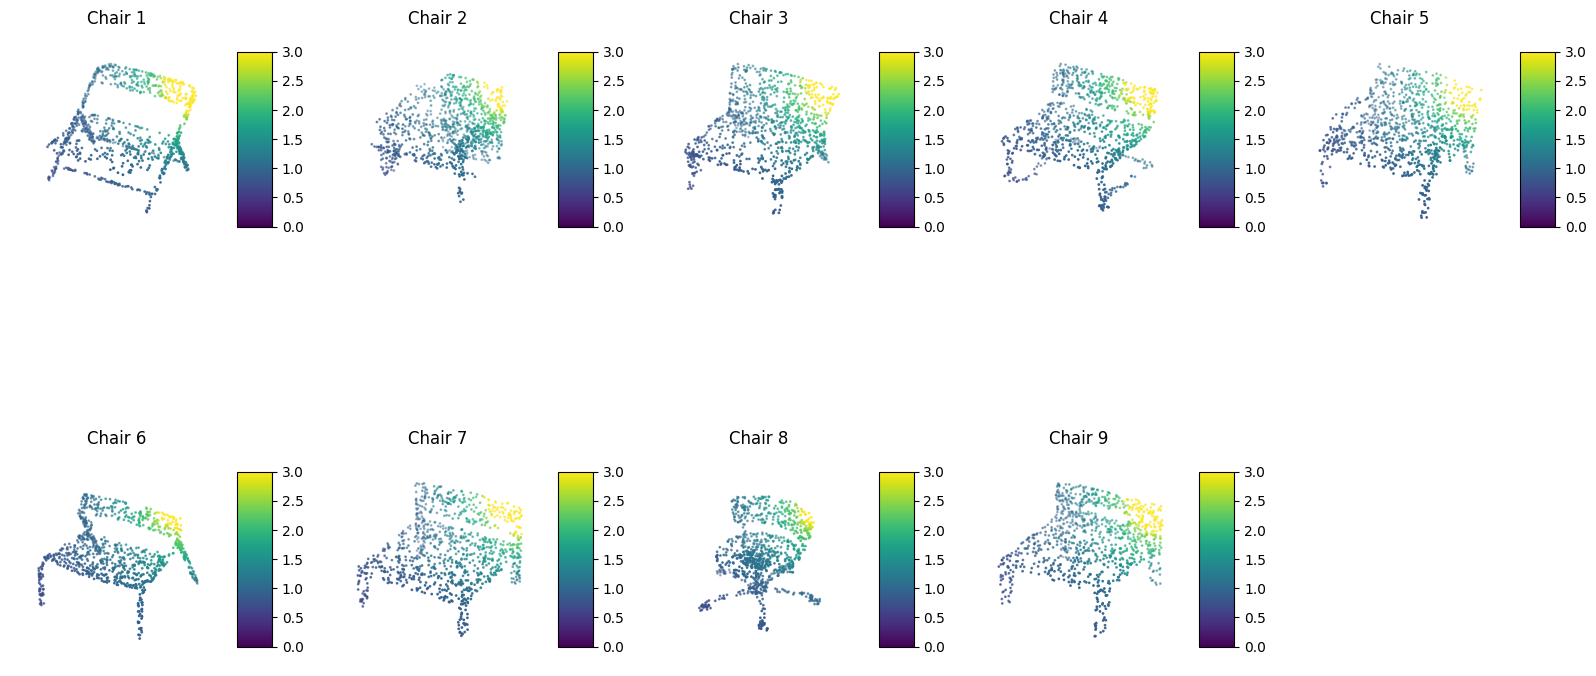

In [24]:
# T 値の推論と可視化
fig = plt.figure(figsize=(20, 10))

for i, pointcloud in enumerate(input_data_list2):
    # 入力データ (x, y, z) を PINN に通す
    input_tensor = torch.tensor(pointcloud, dtype=torch.float32)
    with torch.no_grad():
        T_pred = pinn(input_tensor).numpy()  # T の予測

    # 3D プロット
    ax = fig.add_subplot(2, 5, i+1, projection='3d')
    scatter = ax.scatter(pointcloud[:, 0], pointcloud[:, 1], pointcloud[:, 2], c=T_pred[:, 0], cmap='viridis', s=1, vmin=0, vmax=3)
    ax.set_title(f'Chair {i+1}')
    ax.axis('off')

    # カラーバーを追加
    fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)

plt.show()

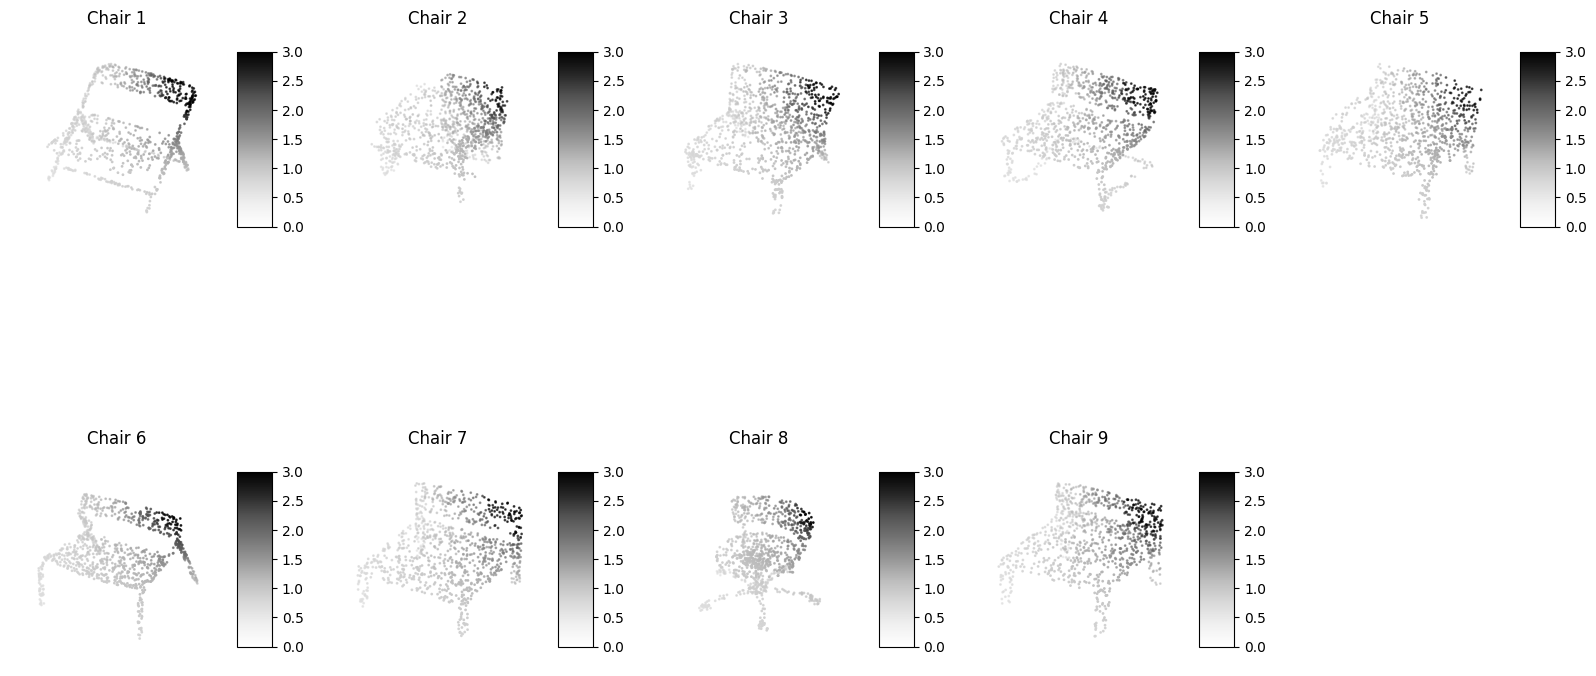

In [25]:
# T 値の推論と可視化
fig = plt.figure(figsize=(20, 10))

for i, pointcloud in enumerate(input_data_list2):
    # 入力データ (x, y, z) を PINN に通す
    input_tensor = torch.tensor(pointcloud, dtype=torch.float32)
    with torch.no_grad():
        T_pred = pinn(input_tensor).numpy()  # T の予測

    # 3D プロット
    ax = fig.add_subplot(2, 5, i+1, projection='3d')
    scatter = ax.scatter(pointcloud[:, 0], pointcloud[:, 1], pointcloud[:, 2], c=T_pred[:, 0], cmap='Greys', s=1, vmin=0, vmax=3)
    ax.set_title(f'Chair {i+1}')
    ax.axis('off')

    # カラーバーを追加
    fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)

plt.show()


In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# training setting
eta = 0.0001
epochs = 3000
batch_size = 1
interval = 10

num_points = 1000
n_in_out = 3 * num_points
n_mid1 = 512
n_mid2 = 256
n_mid3 = 128
n_mid4 = 64
n_mid5 = 32
n_z = 2  # 潜在変数の数
con_dim = 1  # 条件次元（任意で変更）
con_z_values = [0.45, 0.9]  # 2つの水準値

class conVAE(nn.Module):
    def __init__(self):
        super(conVAE, self).__init__()

        # PointNet Encoder
        self.conv1 = nn.Conv1d(n_in_out, 64, kernel_size=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=1)
        self.conv3 = nn.Conv1d(128, 1024, kernel_size=1)
        self.maxpool = nn.AdaptiveMaxPool1d(1)
        self.linear1 = nn.Linear(1024, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, 9)
        self.enc_mu = nn.Linear(9, n_z)
        self.enc_logvar = nn.Linear(9, n_z)

        # Decoder
        self.dec1 = nn.Linear(n_z + con_dim, n_mid5)  # 修正: con_zも考慮
        self.dec2 = nn.Linear(n_mid5, n_mid4)
        self.dec3 = nn.Linear(n_mid4, n_mid3)
        self.dec4 = nn.Linear(n_mid3, n_mid2)
        self.dec5 = nn.Linear(n_mid2, n_mid1)
        self.dec_out = nn.Linear(n_mid1, n_in_out)

        # Weight initialization
        self._init_weights()

    def forward(self, x, con_z):  # con_zも渡すように変更
        z, mu, logvar = self.encode(x)
        y = self.decode(z, con_z)
        return y, z

    def encode(self, x):
        x = x.reshape(1, n_in_out, 1)
        x = F.leaky_relu(self.conv1(x), negative_slope=0.001)
        x = F.leaky_relu(self.conv2(x), negative_slope=0.001)
        x = F.leaky_relu(self.conv3(x), negative_slope=0.001)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)  # フラット化してlinear層に接続
        x = F.leaky_relu(self.linear1(x), negative_slope=0.001)
        x = F.leaky_relu(self.linear2(x), negative_slope=0.001)
        x = self.linear3(x)
        mu = self.enc_mu(x)
        logvar = self.enc_logvar(x)
        std = torch.exp(0.5 * logvar)  # sigma
        eps = torch.randn_like(std)  # 正規分布に従う乱数
        z = mu + std * eps  # 潜在変数
        self.mu = mu
        self.logvar = logvar
        return z, mu, logvar

    def decode(self, z, con_z):
      # 修正: con_zの次元をzに揃える
      #con_z = con_z.unsqueeze(-1)  # con_zの次元を (batch_size, 1) にする
      #con_z = con_z.expand(z.size(0), z.size(1))  # con_zの次元を (batch_size, latent_dim) に揃える
      z = z.squeeze(0)
      # Latent Space Zとcon_zを結合
      z = torch.cat([z, con_z], dim=-1)  # 次元を一致させてから結合

      # 結合後の形状を確認
      #print(f"Shape of z after concatenation: {z.shape}")
      x = F.leaky_relu(self.dec1(z), negative_slope=0.001)
      x = F.leaky_relu(self.dec2(x), negative_slope=0.001)
      x = F.leaky_relu(self.dec3(x), negative_slope=0.001)
      x = F.leaky_relu(self.dec4(x), negative_slope=0.001)
      x = F.leaky_relu(self.dec5(x), negative_slope=0.001)
      x = self.dec_out(x)  # 最終的な出力層
      return x


    def clipped_pena_loss(self, T_pred, con_z):
        T_max = 0.9  # 最大値（適宜調整）
        T_pena = con_z * T_max  # 上限値の設定
        # T_predがT_pena(上限)を超える場合のペナルティを追加
        penalty = torch.relu(T_pred - T_pena) ** 2
        loss = torch.mean(penalty)
        return loss

    def loss(self, y, x, con_z):
        # xを(batch_size, 3)の形に変換
        x_reordered = y.view(3, -1).transpose(0, 1)
        # PINN model Prediction
        T_pred = pinn(x_reordered)

        # clip_loss を1点ずつ算出して合計
        clip_loss = 0
        for i in range(T_pred.size(0)):  # T_pred の各点に対してループを回す
            clip_loss += self.clipped_pena_loss(T_pred[i].unsqueeze(0), con_z)  # 修正: con_zを追加

        rec_loss = F.mse_loss(y, x, reduction="sum")  # 再構成誤差をMSEで計算
        reg_loss = 0.5 * torch.sum(self.mu ** 2 + torch.exp(self.logvar) - self.logvar - 1)  # 正則化項

        return rec_loss, reg_loss, clip_loss

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

vae = conVAE()
print(vae)
# vae.cuda()

from torch import optim

optimizer = optim.Adam(vae.parameters(), lr=eta)

rec_error_record = []
clip_error_record = []
reg_error_record = []
total_error_record = []
z_list = []



conVAE(
  (conv1): Conv1d(3000, 64, kernel_size=(1,), stride=(1,))
  (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
  (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
  (maxpool): AdaptiveMaxPool1d(output_size=1)
  (linear1): Linear(in_features=1024, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=9, bias=True)
  (enc_mu): Linear(in_features=9, out_features=2, bias=True)
  (enc_logvar): Linear(in_features=9, out_features=2, bias=True)
  (dec1): Linear(in_features=3, out_features=32, bias=True)
  (dec2): Linear(in_features=32, out_features=64, bias=True)
  (dec3): Linear(in_features=64, out_features=128, bias=True)
  (dec4): Linear(in_features=128, out_features=256, bias=True)
  (dec5): Linear(in_features=256, out_features=512, bias=True)
  (dec_out): Linear(in_features=512, out_features=3000, bias=True)
)


In [29]:

for i in range(epochs):
    vae.train()
    loss_rec = 0
    loss_reg = 0
    loss_clip = 0
    loss_total = 0

    for j in range(2):  # con_zを2条件でループ
        con_z = torch.tensor([con_z_values[j]])  # 0.45, 0.9を交互に設定
        #print(con_z)
        for k, (x,) in enumerate(data_loader):
            # x = x.cuda()
            x = x.squeeze(0)
            y, z = vae(x, con_z)  # 修正: con_zを追加
            lrec, lreg, closs = vae.loss(y, x, con_z)  # 修正: con_zを追加
            loss = lrec + lreg + closs
            loss_rec += lrec.item()
            loss_reg += lreg.item()
            loss_clip += closs.item()
            loss_total += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if i == epochs - 1:
                z_list.append(z.cpu().detach().numpy())

    # 平均を計算
    loss_rec /= (j + 1) * (k + 1)
    loss_reg /= (j + 1) * (k + 1)
    loss_clip /= (j + 1) * (k + 1)
    loss_total /= (j + 1) * (k + 1)
    rec_error_record.append(loss_rec)
    clip_error_record.append(loss_clip)
    reg_error_record.append(loss_reg)
    total_error_record.append(loss_total)
    if i % interval == 0:
        print(f"Epoch:{i} Loss_Rec:{loss_rec} Loss_Reg:{loss_reg} Loss_clip:{loss_clip} Loss_Total:{loss_total}")

z_list = np.concatenate(z_list, axis=0)

Epoch:0 Loss_Rec:1139.8599073621963 Loss_Reg:0.05891299247741699 Loss_clip:30.91753684149848 Loss_Total:1170.8363647460938
Epoch:10 Loss_Rec:342.5642784966363 Loss_Reg:15.214358276791042 Loss_clip:168.689826991823 Loss_Total:526.4684668646919
Epoch:20 Loss_Rec:341.9001295301649 Loss_Reg:9.895873096254137 Loss_clip:169.81346729066638 Loss_Total:521.6094631618923
Epoch:30 Loss_Rec:329.4511973063151 Loss_Reg:7.1024863719940186 Loss_clip:157.1676927142673 Loss_Total:493.72137451171875
Epoch:40 Loss_Rec:324.0009028116862 Loss_Reg:5.932646195093791 Loss_clip:156.6726198196411 Loss_Total:486.60616217719183
Epoch:50 Loss_Rec:323.7303941514757 Loss_Reg:4.948187748591105 Loss_clip:157.05068069034152 Loss_Total:485.72926245795355
Epoch:60 Loss_Rec:326.56117757161456 Loss_Reg:4.417021380530463 Loss_clip:157.66233836279974 Loss_Total:488.6405334472656
Epoch:70 Loss_Rec:328.4129935370551 Loss_Reg:3.8049292299482556 Loss_clip:155.8080997467041 Loss_Total:488.0260238647461
Epoch:80 Loss_Rec:325.297020

KeyboardInterrupt: 

# 以下不要

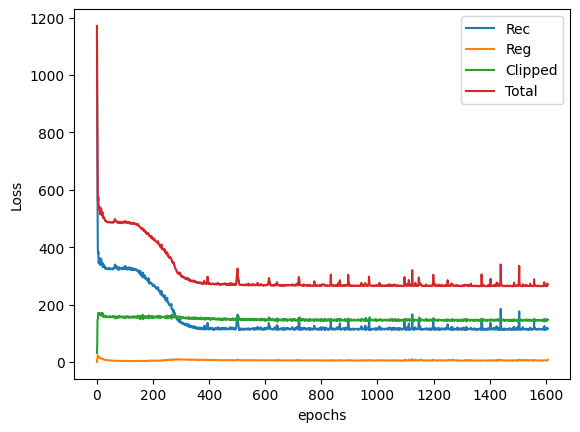

In [30]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(rec_error_record)+1),rec_error_record,label="Rec")
plt.plot(range(1, len(reg_error_record)+1),reg_error_record,label="Reg")
plt.plot(range(1, len(clip_error_record)+1),clip_error_record,label="Clipped")
plt.plot(range(1, len(total_error_record)+1),total_error_record,label="Total")
plt.legend()

plt.xlabel("epochs")
plt.ylabel("Loss")
plt.show()

In [31]:
# model save
torch.save(vae.state_dict(),'/content/drive/MyDrive/chair/outsidepinn_cvae_weights_0930.pth')
print("Model weights have been saved!")

Model weights have been saved!


In [33]:
z_list

[]

In [32]:
for i in range(9):
  print(z_list[i])


IndexError: list index out of range

zの空間は下記の通り。
* [-1.8858097  0.7790367]
* [ 2.1339314 -1.6015382]
* [1.9603361 1.7932936]
* [-2.0508573 -0.6184593]
* [-0.41351536  2.1901774 ]
* [-0.99794996 -1.7791438 ]
* [0.9675941 2.746491 ]
* [2.124693   0.39886042]
* [-1.4709967  1.4940743]

In [44]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def plot_point_cloud(xs, ys, zs, title="Point Cloud", ax=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        show_plot = True
    else:
        show_plot = False

    ax.scatter(xs, ys, zs, s=1)
    ax.set_title(title)
    if show_plot:
        plt.show()

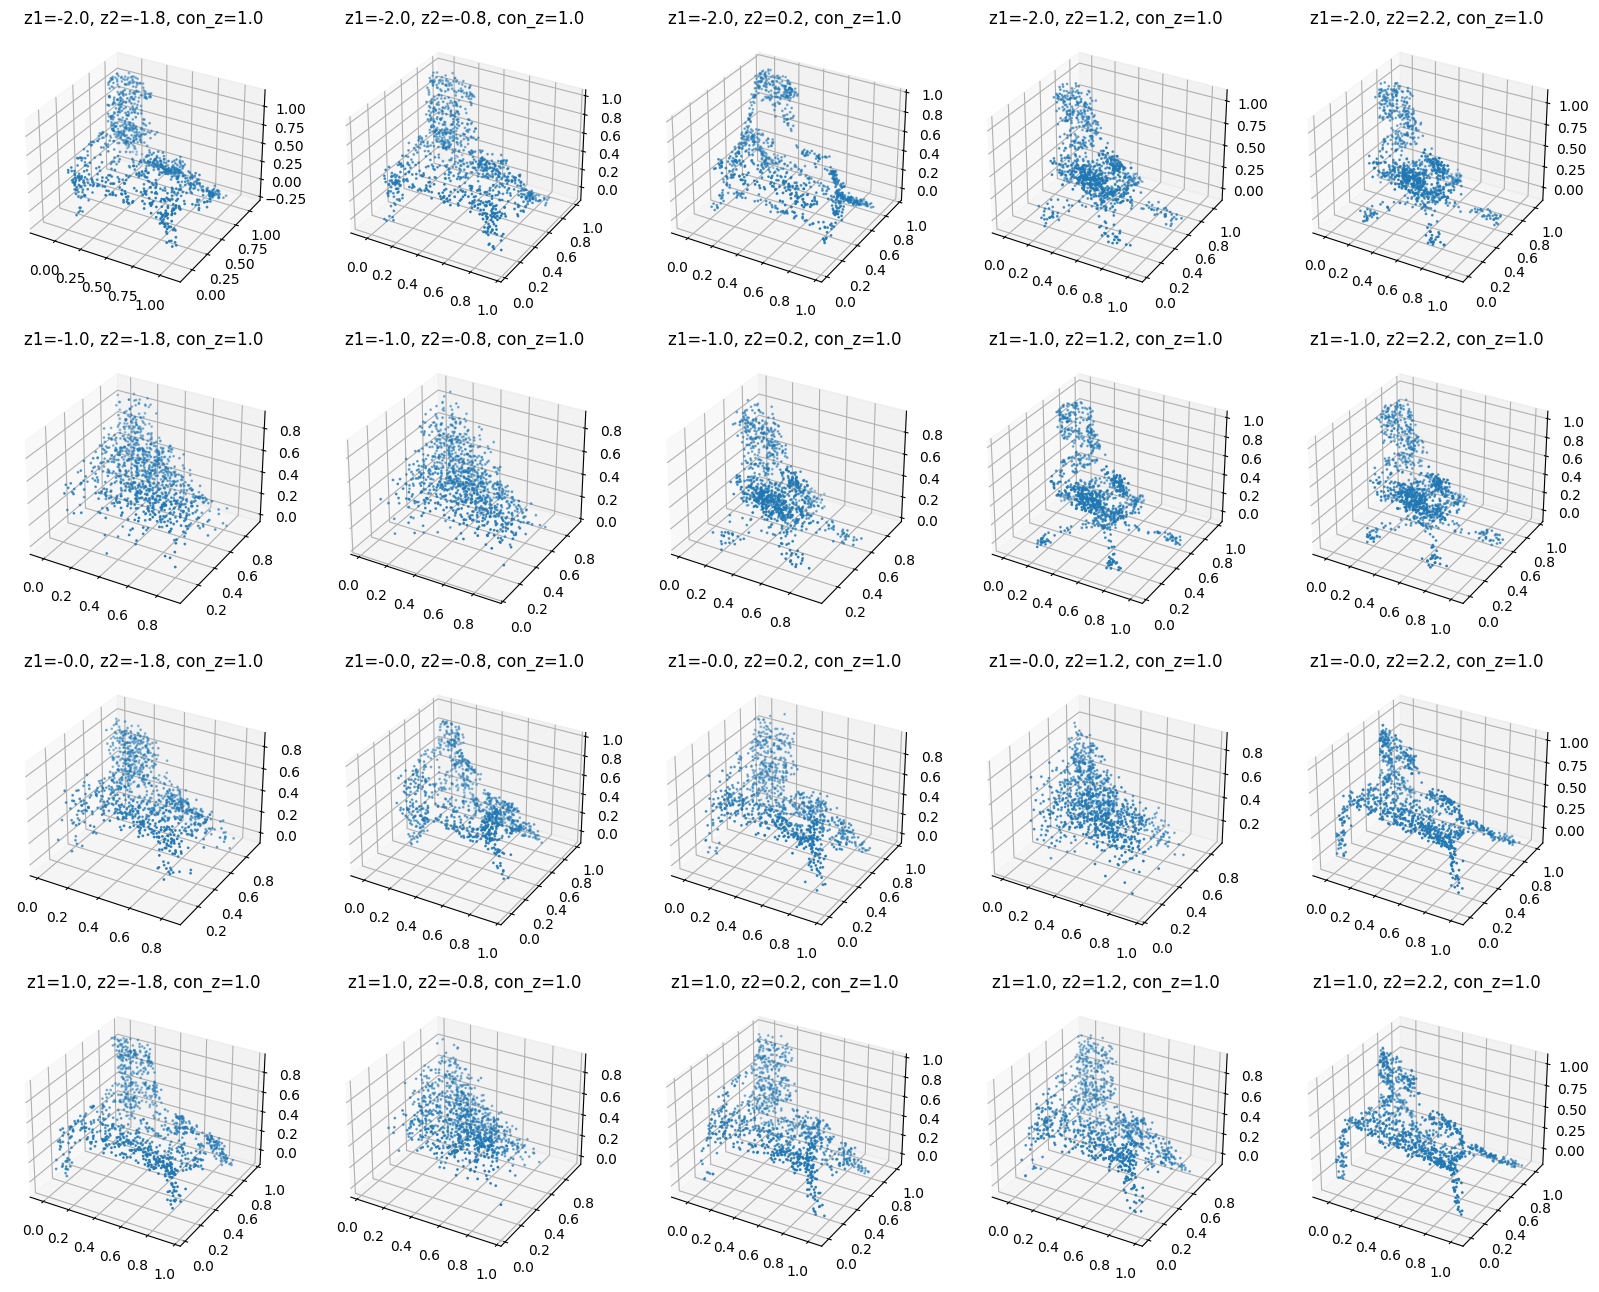

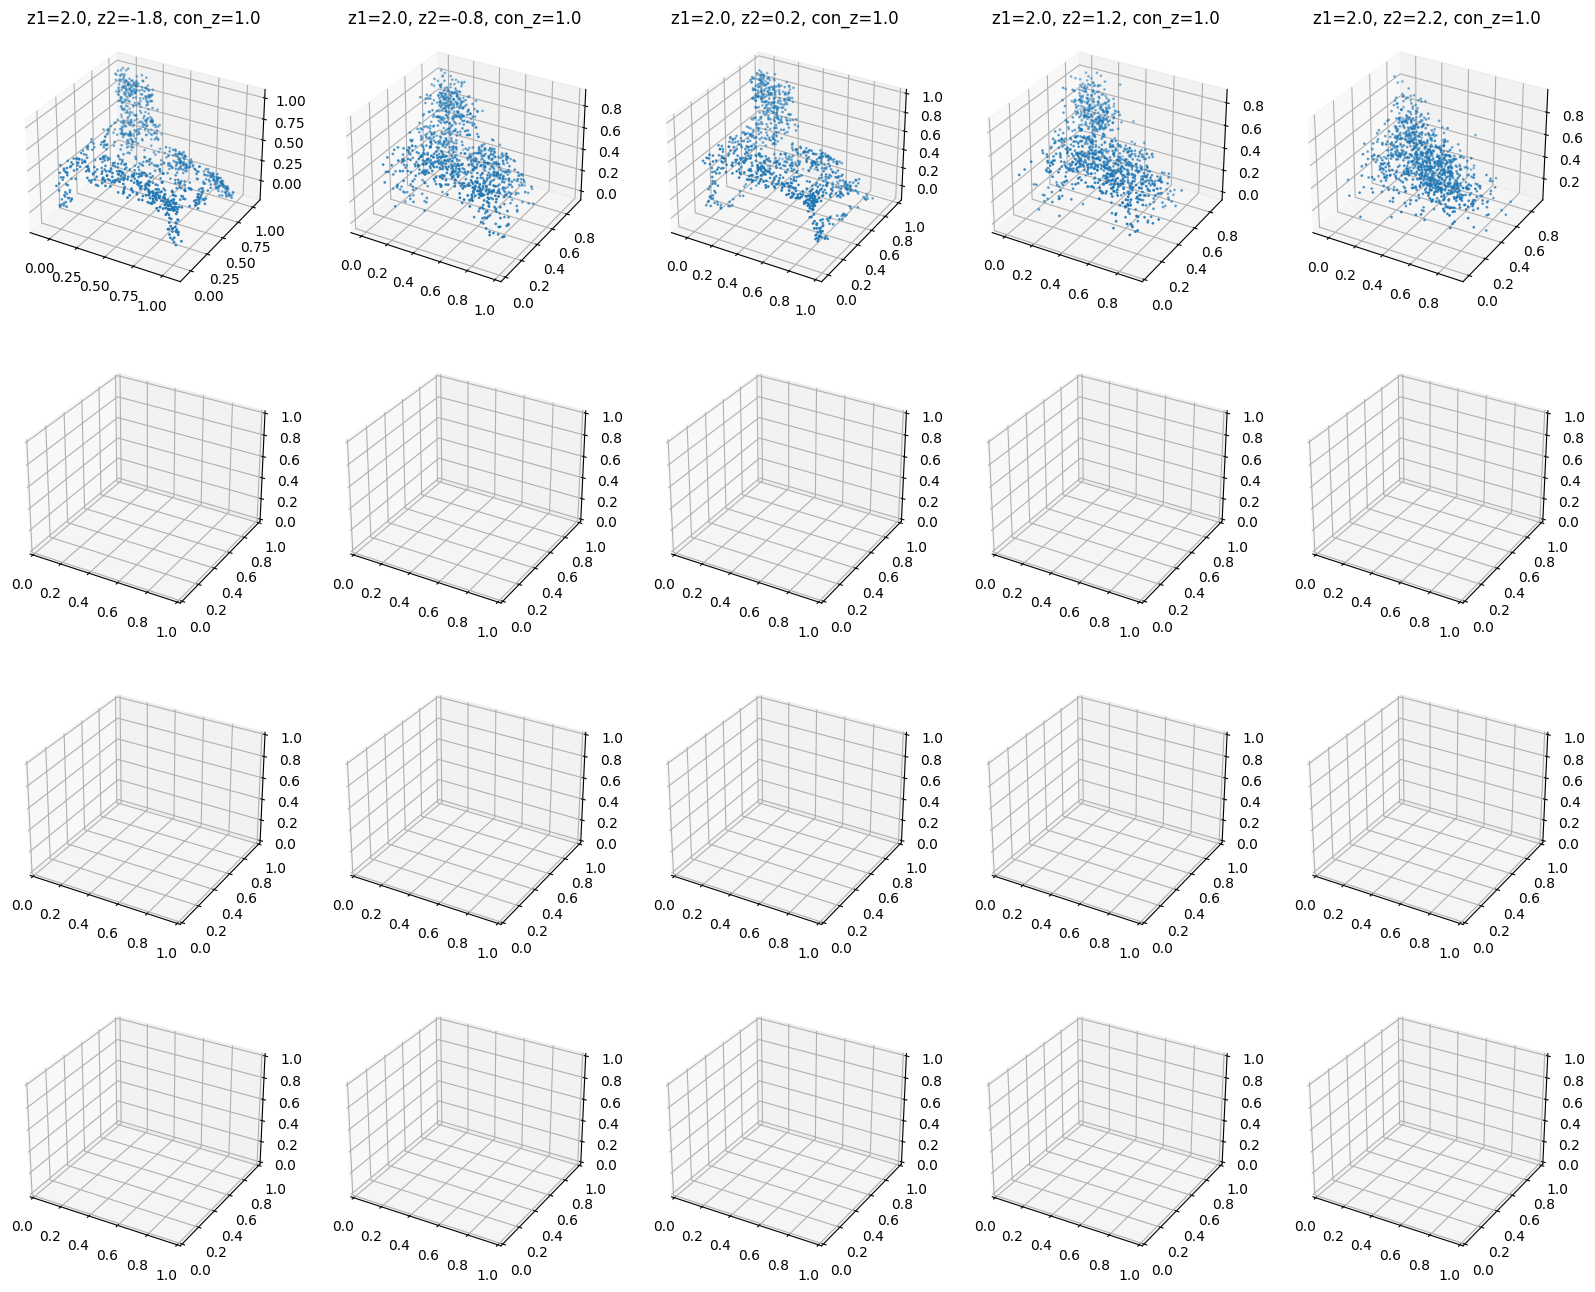

In [50]:
num_points=1000

# ループして潜在変数を変化させ、再構築と可視化を行う
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20, 16), subplot_kw={'projection': '3d'})
axes = axes.flatten()
z1_min = -2.05
z1_max = 2.13
z2_min = -1.77
z2_max = 2.74
con_z=1.0
index = 0
for z1 in np.arange(z1_min, z1_max, 1.0):
    for z2 in np.arange(z2_min, z2_max, 1.0):
        if index >= len(axes):
            plt.show()
            fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20, 16), subplot_kw={'projection': '3d'})
            axes = axes.flatten()
            index = 0

        # 修正: np.array([z1, z2]) を torch.tensor に変換
        z_mod = torch.tensor([z1, z2], dtype=torch.float32)
        # con_zを1次元テンソルに変換
        con_z_tensor = torch.tensor([con_z], dtype=torch.float32)


        # 再構築
        recon_batch2 = vae.decode(z_mod.unsqueeze(0), con_z_tensor)  # 入力は (1, 2) 形状にする必要がある場合が多い
        # 修正: CPU上で detach してから numpy() に変換
        reconst2 = recon_batch2.cpu().detach().numpy().reshape(-1)

        # 修正: num_points 変数が定義されているか確認
        reconst2_x = reconst2[:num_points]
        reconst2_y = reconst2[num_points:2*num_points]
        reconst2_z = reconst2[2*num_points:3*num_points]
        # reconst2_t = reconst2[3*num_points:4*num_points]  # もし必要ならば

        title = f"z1={z1:.1f}, z2={z2:.1f}, con_z={con_z:.1f}"
        plot_point_cloud(reconst2_x, reconst2_y, reconst2_z, title, axes[index])
        index += 1

# 最後に残ったプロットを表示
if index > 0:
    plt.show()
